In [1]:
# first version of own program struggle with storing variables in a class, and backpropagating bias was a bit of a mess.
# https://github.com/SkalskiP/ILearnDeepLearning.py/blob/master/01_mysteries_of_neural_networks/03_numpy_neural_net/Numpy%20deep%20neural%20network.ipynb

In [68]:
#importing packages
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score,mean_squared_error,r2_score
from sklearn.linear_model import SGDClassifier
import scipy.linalg as scl
import matplotlib.pyplot as plt
import seaborn as sn
import sys
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator,FormatStrFormatter
import scikitplot as skplt

sn.set(style="white") #fixes ugly backgrounds

# confusion matrix plotter

In [3]:
"""
Input:
    y_real: real data
    y_pred: predicted data
    labs: labels for each class
Output:
    prints a confusion matrix
"""
def plot_confusion(y_real,y_pred,labs):
    if not labs:
        labs = np.unique(y_real)
#     y_real=y_real[:,np.newaxis]
    y_pred=y_pred.reshape(y_real.shape)
    confused = confusion_matrix(y_real,y_pred,sample_weight = None)
    df_cm = pd.DataFrame(confused,columns=labs, index=labs)

    df_cm.index.name = 'Actual'
    df_cm.columns.name ='Predicted'
    plt.figure(figsize=(10,7))
    sn.set(font_scale=1.4)
    ax = sn.heatmap(df_cm, cmap="inferno",annot=True, fmt='g',annot_kws={"size":16})
    first,second=ax.get_ylim()
    ax.set_ylim(first+0.5,0)
    sn.set(style="white") #fixes ugly backgrounds

# decreasing lr

In [4]:
"""
An attempt at adaptive learning rate.
It failed for NN, kept in case we want to include it later
"""
def decreasing_lr(t): 
#this function is seemingly a bit naive, t0 and t1 should be set by Nepochs and Nbatches maybe?
        t0,t1 = 50,500
#         t0,t1 = 5,50
        
        return t0/(t+t1)

# area ratio calculator

In [63]:
def calc_area_ratio(pred,real):
    fig,ax = plt.subplots(1,1)
    y_te = two(pred)
    skplt.metrics.plot_cumulative_gain(real.ravel(), y_te,ax=ax)
    ax.grid(b=None)
    hh,ll=ax.get_legend_handles_labels()
    plt.close()
    defaults = sum(real == 1)
    total = len(real)
    defaultRate = defaults/total

    bestie=bestCurve(defaults,total,defaultRate)
    dia = np.linspace(0,1,15000)
    classi=hh[1].get_ydata()
    diff_c = np.sum(classi)-np.sum(dia)
    diff_b = np.sum(bestie[1])-np.sum(dia)+1 #adding a 1 on the end of bestie for dimensions?
    area_ratio = diff_c/diff_b
    return area_ratio,hh

In [65]:
def two(y): #helper function for lift curve plotting
    y_two = np.zeros(len(y))
    for i in range(len(y)):
        y_two[i] = 1-y[i]
    return np.c_[y_two,y]

In [66]:
def bestCurve(defaults, total, defaultRate): #create best curve
    x = np.linspace(0, 1, total)
    
    y1 = np.linspace(0, 1, defaults)
    y2 = np.ones(total-defaults)
    y3 = np.concatenate([y1,y2])
    return x, y3

# define activation/deactivation functions

In [35]:
"""
Activation functions with their derivatives for forward and backwards propagation.
Input:
    s: the z-vectors from z=X@weights+bias
Output:
    what you'd expect, I guess
"""
def sigmoid(s):
    return 1./(1.+np.exp(-s))
def sigmoid_backprop(x):
    sig = sigmoid(x)
    return sig*(1-sig)

def ReLU(s):
    return np.maximum(0,s) 
def ReLU_backprop(x):
    rel = ReLU(x)
    rel[rel>0]=1
    return rel

def tanh(s):
    return np.tanh(s)
def tanh_backprop(x):
    tan = tanh(x)
    return (1-tan*tan)

def softsign(s):
    return s/(1+np.abs(s))
def softsign_backprop(x):
    return 1./(1+np.abs(x))**2

def LReLU(s):
    return np.where(s>0,s,s*0.01)
def LReLU_backprop(x):
    rel = np.ones_like(x)
    rel[x<0] = 0.01
    return rel

def ReLU6(s):
    rel = np.minimum(np.maximum(0,s),6)
    return rel
def ReLU6_backprop(x):
    rel = np.zeros_like(ReLU6(x))
    rel[x<=6]=1
    rel[x<=0]=0
    return rel

def regression(s):
    return s
def regression_backprop(x):
    return 1

# create dictionaries for activation/deactivation functions (avoids if tests!)

In [6]:
activation_functions = {'sigmoid' :sigmoid,
                        'ReLU':ReLU, 
                        'tanh':tanh, 
                        'LReLU':LReLU, 
                        'softsign':softsign,
                        'ReLU6':ReLU6,
                        'regression':regression}

deactivation_functions = {'sigmoid' : sigmoid_backprop, 
                          'ReLU': ReLU_backprop, 
                          'tanh': tanh_backprop, 
                          'LReLU': LReLU_backprop, 
                          'softsign': softsign_backprop,
                          'ReLU6':ReLU6_backprop,
                          'regression':regression_backprop}

# NN class

In [7]:
"""
NeuralNetwork code with misleading name.
Input:
    XTrain, yTrain,XTest,yTest: self-explanatory. shape(num_data_entries,num_features)
    
    nodes_per_layer: array containing # of nodes for each hidden layer. Output layer 
        handled automatically.
    
    activation_per_layer: array containing string name of activation function, taken from 
        activation dictionary above.
    
    lmbd: lambda value for l2 regularization, default: 0.0 (commented out currently)
    
    classification: boolean, True if classification, False if regression. Default: True
    
    epochs: number of epochs, default:10000
    
    batch_size: number of batches per epoch, default: 100
    
    eta: learning rate, default: 0.01
    
    seed: random seed to easily replicate data, default: 99
    
    minibatches: boolean, turn minibatches on or off. default: True (on)
    
    initialization_method: string; either 'xavier' or 'standard', where standard is just 
        random weights and biases. default: xavier
        
Methods:
    initialize: sets up initial weights and biases according to initialization method.
        used by the training method, and not really called outside class.
    
    forward_propagation: 
        Input:
            X: feature matrix to feed forward.
        Output: 
            predicted values for X on this network.
        used during training, but also to predict final 
        values for accuracy tests and such
    
    backward_propagation: performs backprop, no input or output here
    
    cross_entropy: misnamed function for calculating cost.
        Input:
            y_pred,y_real: selfexplanatory
        Output:
            cost of y_real and y_pred using chosen cost function
    
    accuracy: as cross_entropy, but for accuracy
    
    update: updates weights after each epoch.
        Input:
            i,j: integers for adaptive learning rate
    
    train: slaps the above together into a functional NN      
    
"""
class binaryNN:
    def __init__(
            self,
            XTrain,
            yTrain,
            XTest,
            yTest,
            nodes_per_layer,
            activation_per_layer,
            lmbd=0.0,
            classification=True,
            epochs = 10000,
            batch_size=100,
            eta=0.01,
            seed=99,
            minibatches=True,
            initialization_method = 'xavier'
        ):
        self.XTrain = XTrain
        self.yTrain = yTrain.T
        self.XTest  = XTest
        self.yTest  = yTest
        self.seed   = seed
        self.classification = classification
        self.lmbd = lmbd
        self.minibatches=minibatches
        
        # add final layer, 1 output node, using the sigmoid or linear activation 
        self.nodes_per_layer = nodes_per_layer.copy()
        self.nodes_per_layer.extend([1])

        self.activation_per_layer = activation_per_layer.copy()
        if self.classification:
            self.activation_per_layer.extend(['sigmoid'])
        else:
            self.activation_per_layer.extend(['regression'])
        

        self.eta = eta
        self.epochs = epochs
        self.batch_size = batch_size
        self.iterations = self.XTrain.shape[0] // self.batch_size
        self.method=initialization_method
        
    def initialize(
            self
        ):
        np.random.seed(self.seed)
        number_of_layers = len(self.activation_per_layer)
        self.nodes_per_layer = np.hstack((self.XTrain.shape[1],self.nodes_per_layer))
        self.parameter_values={}
        for idx in range(len(self.activation_per_layer)):
            layer_idx = idx+1
            layer_input_size = self.nodes_per_layer[idx]
            layer_output_size = self.nodes_per_layer[idx+1]
            np.random.seed(self.seed)
            if self.method == 'standard':
                self.parameter_values['W'+str(layer_idx)] = np.random.randn(
                                    layer_output_size,layer_input_size)*0.1
                self.parameter_values['b'+str(layer_idx)] = np.random.randn(
                                    layer_output_size,1)*0.1   

            elif self.method == 'xavier':
                stdd = np.sqrt(2/(layer_output_size+layer_input_size))
                self.parameter_values['W'+str(layer_idx)] = np.random.normal(
                                    0.0,stdd,size=(layer_output_size,layer_input_size))
                self.parameter_values['b'+str(layer_idx)] = 0
    def forward_propagation(
        self,
        X
        ):
        self.layer_dict = {}
        self.a_current = X.T
        for idx in range(len(self.activation_per_layer)):
            layer_idx = idx+1
            self.a_previous = self.a_current
            self.W_current = self.parameter_values["W"+str(layer_idx)]
            self.b_current = self.parameter_values["b"+str(layer_idx)]
            
            self.z_current = self.W_current@self.a_previous+self.b_current
            self.a_current = activation_functions[self.activation_per_layer[idx]](self.z_current)
            
            self.layer_dict["a"+str(idx)] = self.a_previous
            self.layer_dict["z"+str(layer_idx)] = self.z_current
        return self.a_current
    
    def backward_propagation(
        self,
        y
        ):
        #da is dCost/dactivation
         #dz is dactivation/dz
        self.yBatch = y.T
        self.gradient_values={}
        m = self.yBatch.shape[0]
        if self.classification:
            da_previous = -(np.divide(self.yBatch,self.a_current)-np.divide(1-self.yBatch,1-self.a_current))
        else:
            da_previous = 2.*(self.a_current-self.yBatch)
        for layer_idx_previous in reversed(range(len(self.activation_per_layer))):
            layer_idx_current = layer_idx_previous + 1
            da_current = da_previous

            a_previous = self.layer_dict["a" + str(layer_idx_previous)]
            z_current = self.layer_dict["z" + str(layer_idx_current)]
            W_current = self.parameter_values["W" + str(layer_idx_current)]
            b_current = self.parameter_values["b" + str(layer_idx_current)]

            n = a_previous.shape[1]
            dz_current = da_current*deactivation_functions[self.activation_per_layer[layer_idx_current-1]](z_current)
#             NO REGULARIZATION
            dW_current = dz_current@a_previous.T/n
#             dW_current = dz_current@a_previous.T/n \
#                         + (self.lmbd/n)*self.parameter_values["W" + str(layer_idx_current)]

            db_current = np.sum(dz_current,axis=1,keepdims=True)/n
            da_previous = W_current.T@dz_current
            
            self.gradient_values["dW" + str(layer_idx_current)] = dW_current
            self.gradient_values["db" + str(layer_idx_current)] = db_current 
            
    ### COST STUFF
    def cross_entropy(
        self,
        y_pred,
        y_real
        ):
        n = y_pred.shape[1]
        if self.classification:
#             l2_cost = 0
#             for i in range(1,len(self.activation_per_layer)):
#                 l2_cost += np.sum(np.square(self.parameter_values["W"+str(i)]))
#                 NO REGULARIZATION
#             cost = (-1./y_pred.shape[1])*((y_real@(np.log(y_pred).T)+(1-y_real)@(np.log(1-y_pred)).T))
            cost = (-1./n)*((y_real@(np.log(y_pred).T)+(1-y_real)@(np.log(1-y_pred)).T))# \
#                 +(2./n)*self.lmbd*l2_cost

        else:
#             l2_cost = 0
#             for i in range(1,len(self.activation_per_layer)):
#                 l2_cost += np.sum(np.square(self.parameter_values["W"+str(i)]))
            cost= mean_squared_error(np.squeeze(y_pred),np.squeeze(y_real))# \
#                 + (2./n)*self.lmbd*l2_cost
        return cost
    
    def accuracy(
        self,
        y_pred,
        y_real
        ):
        if y_pred.shape[0] != 1:
            y_pred = y_pred.reshape(1,y_pred.shape[0])
        y_real = y_real.reshape(y_pred.shape)
        y_pred_classed = np.copy(y_pred)
        y_pred_classed[y_pred_classed>0.5]=1
        y_pred_classed[y_pred_classed<=0.5]=0
        return (y_pred_classed==y_real).all(axis=0).mean()
    
    ## UPDATE WEIGHTS AND BIASES
    def update(
        self,i,j
        ):
        for layer_idx in range(len(activation_per_layer)):
            layer_idx +=1
#             eta = decreasing_lr(i*self.iterations+j) #decreasing lr method was useless (?)
#             eta=decreasing_lr(i)
            eta=self.eta
            self.parameter_values["W" + str(layer_idx)] -= eta * self.gradient_values["dW" + str(layer_idx)]        
            self.parameter_values["b" + str(layer_idx)] -= eta * self.gradient_values["db" + str(layer_idx)]
            
    def train(
        self
        ):
        self.initialize()
        self.cost_history = []
        self.accuracy_history = []
        self.cost_history_test = []
        self.accuracy_history_test=[]
        data_indices = np.arange(self.XTrain.shape[0])
        for i in range(self.epochs):
            print("Calculating: {}% complete.".format(round(i/self.epochs*100,3)),end="\r")
#             mini batches, not useful for biased data(depending on batch size)? discuss
            if self.minibatches:
                for j in range(self.iterations):
                    chosen_datapoints = np.random.choice(
                        data_indices,size=self.batch_size,replace=False)
                    self.XData = self.XTrain[chosen_datapoints]
                    self.yData = self.yTrain[chosen_datapoints]
                    self.forward_propagation(self.XData)
                    self.backward_propagation(self.yData)
                    self.update(i,j)
              
            else:
                self.forward_propagation(self.XTrain)
                self.backward_propagation(self.yTrain)
                self.update(i,1)
            
            
            trainer = self.forward_propagation(self.XTrain)
            cost = self.cross_entropy(trainer,self.yTrain)
            self.cost_history.append(cost)
            accuracy = self.accuracy(trainer, self.yTrain)
            self.accuracy_history.append(accuracy)
            
            tester = self.forward_propagation(self.XTest)
            cost_test = self.cross_entropy(tester,self.yTest)
            self.cost_history_test.append(cost_test)
            accuracy_test = self.accuracy(tester, self.yTest)
            self.accuracy_history_test.append(accuracy_test)

            #test
            if self.classification:
                self.y_pred_ = self.forward_propagation(self.XTrain)
                self.y_pred_[self.y_pred_>=0.5]=1
                self.y_pred_[self.y_pred_<0.5]=0
        print("Calculating: {}% complete.      ".format(100),end="\r")


# testing on franke

In [8]:
"""
This is an "uglified" version of the FrankeFunction, to minimize use of costly functions like 
divisions and powers.
It takes as input parameters a meshgrid of coordinates in the x and y direction.
"""
def FrankeFunction(x,y): #still got one division in here
    term1 = 0.75*np.exp(-(0.25*(9*x-2)*(9*x-2)) - 0.25*((9*y-2)*(9*y-2)))
    term2 = 0.75*np.exp(-((9*x+1)*(9*x+1))/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)*(9*x-7)*0.25 - 0.25*((9*y-3)*(9*y-3)))
    term4 = -0.2*np.exp(-(9*x-4)*(9*x-4) - (9*y-7)*(9*y-7))
    return term1 + term2 + term3 + term4

In [36]:
#creating 2 datasets instead of doing train test split for ease of plotting.
N = 150 #number of points along x and y axes

# sort this for meshgrid
x = np.sort(np.random.uniform(0,1,N))
y = np.sort(np.random.uniform(0,1,N))
x, y = np.meshgrid(x,y,sparse=False)

#create datapoints/results
z = FrankeFunction(x, y)

# Create noise
noise_weight = 0.1
Noise = noise_weight*np.random.randn(N,N)

#add noise
z_noise = z+Noise

#flatten for use in functions
z_n = np.matrix.flatten(z_noise)
X_matr = np.c_[np.matrix.flatten(x),np.matrix.flatten(y),z_n]
np.random.shuffle(X_matr)
Xshuf,yshuf = X_matr[:,:2],X_matr[:,2]

N2=20
# sort this for meshgrid
x2 = np.sort(np.random.uniform(0,1,N2))
y2 = np.sort(np.random.uniform(0,1,N2))
x2, y2 = np.meshgrid(x2,y2,sparse=False)

#create datapoints/results
z2 = FrankeFunction(x2, y2)

# Create noise
noise_weight2 = 0.1
Noise2 = noise_weight2*np.random.randn(N2,N2)

#add noise
z_noise2 = z2+Noise2

#flatten for use in functions
z_n2 = np.matrix.flatten(z_noise2)
X_matr2 = np.c_[np.matrix.flatten(x2),np.matrix.flatten(y2),z_n2]
np.random.shuffle(X_matr2)
Xshuf2,yshuf2 = X_matr2[:,:2],X_matr2[:,2]

xtr,ytr,xte,yte = Xshuf[:,:2],yshuf[:],Xshuf2[:,:2],yshuf2[:]


In [37]:
# #nn architecture
# going deeper seems to have a slightly better effect on r2-score than going wider.

nodes_per_layer = [100,100,50,50]
activation_per_layer=['ReLU6','LReLU','ReLU6','LReLU']

In [59]:
frankie = binaryNN(xtr,ytr,xte,yte,nodes_per_layer,activation_per_layer,eta=0.01,classification=False,epochs=1000)
frankie.train()

mse test 0.010437
r2 test 0.8599874
mse train 0.0110561
r2 train 0.8720985


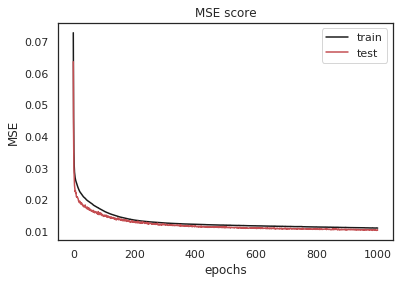

In [61]:
Y_test_franke = np.squeeze(frankie.forward_propagation(xte))
Y_train_franke = np.squeeze(frankie.forward_propagation(xtr))
print("mse test",round(mean_squared_error(Y_test_franke,yte),7))
print("r2 test",round(r2_score(yte,Y_test_franke),7))
print("mse train",round(mean_squared_error(Y_train_franke,ytr),7))
print("r2 train",round(r2_score(ytr,Y_train_franke),7))

plt.title('MSE score')
plt.plot(frankie.cost_history[:],'k',label='train')
plt.plot(frankie.cost_history_test[:],'r',label='test')
plt.xlabel('epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()
#Results in report was achieved with an older version of numpy, not sure why
#anything should've changed though..

# plotting test and train franke

In [ ]:
fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(x2,y2,z_noise2, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title('TEST')
plt.show()

fig = plt.figure()
ax = fig.gca(projection='3d')
xs = np.c_[np.matrix.flatten(x2),np.matrix.flatten(y2)]
zz = frankie.forward_propagation(xs)
zz=zz.reshape((20,20))
surf = ax.plot_surface(x2,y2,zz, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title('TEST')
plt.show()




fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(x,y,z_noise, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title('TRAIN')
plt.show()

fig = plt.figure()
ax = fig.gca(projection='3d')
xs = np.c_[np.matrix.flatten(x),np.matrix.flatten(y)]
zz = frankie.forward_propagation(xs)
zz=zz.reshape((100,100))
surf = ax.plot_surface(x,y,zz, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title('TRAIN')
plt.show()

# bootstrap to calc bias-variance

In [ ]:
xtr,ytr,xte,yte = Xshuf[:,:2],yshuf[:],Xshuf2[:,:2],yshuf2[:]
n_bootstraps = 100
from sklearn.utils import resample

y_pred = np.empty((yte.shape[0], n_bootstraps))
for i in range(n_bootstraps):
    x_, y_ = resample(xtr, ytr)
    frankiestrap = binaryNN(x_,y_,xte,yte,nodes_per_layer,activation_per_layer,classification=False,epochs=1000)
    frankiestrap.train()
    
    # Evaluate the new model on the same test data each time.
    y_pred[:, i] = frankiestrap.forward_propagation(xte)

In [ ]:

error = np.mean( np.mean((yte[:,np.newaxis] - y_pred)**2, axis=1, keepdims=True) )
bias = np.mean( (yte[:,np.newaxis] - np.mean(y_pred, axis=1, keepdims=True))**2 )
variance = np.mean( np.var(y_pred, axis=1, keepdims=True) )
print("MSE",round(error,9))
print("B+V",round(bias+variance,9))
print("Bias",round(bias,9))
print("Variance",round(variance,9))

# testing classification on skl moon data

In [38]:
# number of samples in the data set
N_SAMPLES = 1000
# ratio between training and test sets
TEST_SIZE = 0.1

from sklearn.datasets import make_moons
X_m, y_m = make_moons(n_samples = N_SAMPLES, noise=0.2, random_state=100)
X_train_moons, X_test_moons, y_train_moons, y_test_moons = train_test_split(X_m, y_m, test_size=TEST_SIZE, random_state=42)

In [39]:
Moons = binaryNN(X_train_moons,y_train_moons,X_test_moons, y_test_moons,nodes_per_layer,activation_per_layer,epochs=5000)
Moons.train()

Test set accuracy: 0.99 
Zero set accuracy: 0.54 


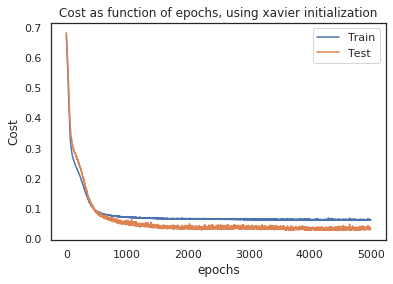

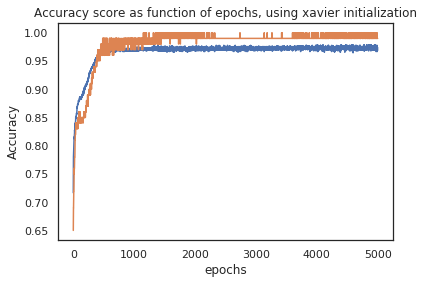

In [42]:
Y_test_hat_moons = Moons.forward_propagation(X_test_moons)
acc_test_moons = Moons.accuracy(Y_test_hat_moons, y_test_moons)
print("Test set accuracy: {:.2f} ".format(acc_test_moons))
zerot_moons = np.zeros(y_test_moons.shape[0])
acc_test_moons2 = Moons.accuracy(y_test_moons, zerot_moons)
print("Zero set accuracy: {:.2f} ".format(acc_test_moons2))

plt.figure()
plt.plot(Moons.cost_history,label='Train')
plt.plot(Moons.cost_history_test,label='Test')
plt.title("Cost as function of epochs, using xavier initialization")
plt.xlabel("epochs")
plt.ylabel("Cost")
plt.legend()
plt.show()


plt.figure()
plt.plot(Moons.accuracy_history,label='Train')
plt.plot(Moons.accuracy_history_test,label='Test')
plt.title("Accuracy score as function of epochs, using xavier initialization")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.show()

In [43]:
Moons_standard = binaryNN(X_train_moons,y_train_moons,X_test_moons,y_test_moons,nodes_per_layer,activation_per_layer,epochs=5000,initialization_method='standard')
Moons_standard.train()

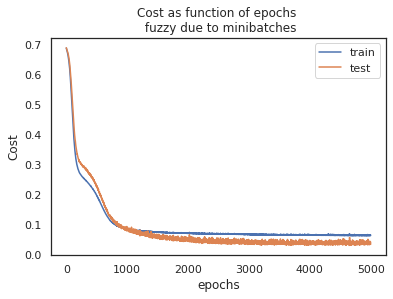

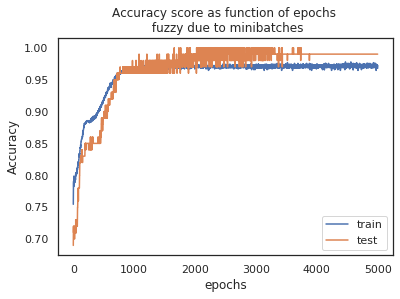

In [44]:
plt.figure()
plt.plot(Moons_standard.cost_history,label='train')
plt.plot(Moons_standard.cost_history_test,label='test')
plt.title("Cost as function of epochs \n fuzzy due to minibatches")
plt.xlabel("epochs")
plt.ylabel("Cost")
plt.legend()
plt.show()


plt.figure()
plt.plot(Moons_standard.accuracy_history,label='train')
plt.plot(Moons_standard.accuracy_history_test,label='test')
plt.title("Accuracy score as function of epochs \n fuzzy due to minibatches")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

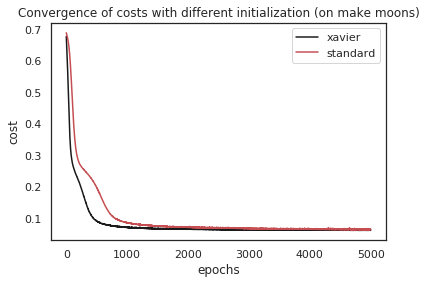

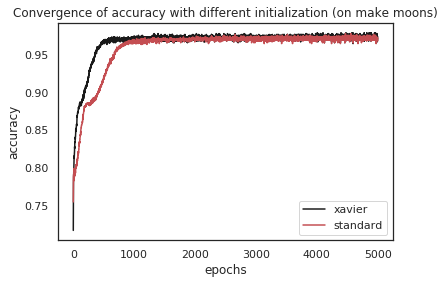

In [45]:

plt.figure()
plt.plot(Moons.cost_history,'k',label='xavier')
plt.plot(Moons_standard.cost_history,'r',label='standard')
plt.xlabel("epochs")
plt.ylabel("cost")
plt.title("Convergence of costs with different initialization (on make moons)")
plt.legend()
plt.show()

plt.figure()
plt.plot(Moons.accuracy_history,'k',label='xavier')
plt.plot(Moons_standard.accuracy_history,'r',label='standard')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("Convergence of accuracy with different initialization (on make moons)")
plt.legend()
plt.show()

# confusion matrix

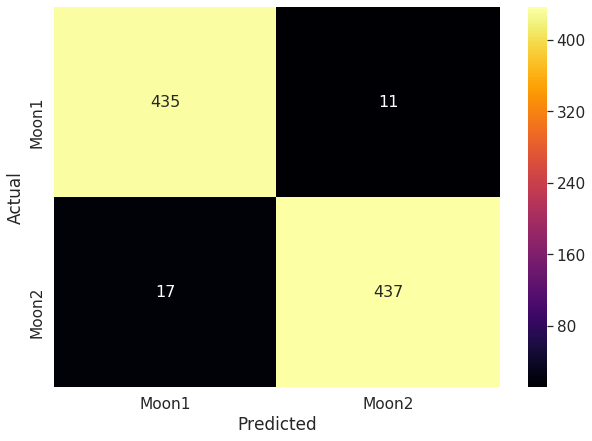

In [46]:
yyy = y_train_moons
ppp = Moons.y_pred_
lab=["Moon1","Moon2"]
plot_confusion(yyy,ppp,lab)

# testing on credit card data

In [47]:
def ReadData():
    #importing data set(s)
    filename = 'default of credit card clients.xls'
    nanDict = {} #this does nothing with this data set
    #read file
    df = pd.read_excel(filename,header=1,skiprows=0,index_col=0,na_values=nanDict) 
    #rename last column
    df.rename(index=str, columns={"default payment next month": "defaultPaymentNextMonth"}, inplace=True)
    #Replace nonsensical values in PAY_i columns with 0
    for i in [0,2,3,4,5,6]:
        col = 'PAY_{}'.format(i)
        df[col].replace(to_replace=-2, value = 0, inplace=True)
    #shuffle dataset by row
    df.sample(frac=1)
    
    # Define features and targets 
    X = df.loc[:, df.columns != 'defaultPaymentNextMonth'].values
    y = df.loc[:, df.columns == 'defaultPaymentNextMonth'].values
    
    # Categorical variables to one-hots, setting nonsensical values to 0
    onehotencoder1 = OneHotEncoder(categories='auto')
    onehotencoder2 = OneHotEncoder(categories='auto',drop='first')

    # sets number of elements in onehot vectors automatically from data.
    Xt= ColumnTransformer(
        [("one", onehotencoder1, [1]),("two", onehotencoder2, [2,3]),],
        remainder="passthrough"
    ).fit_transform(X)

    # Train-test split
    trainingShare = 0.5
    seed  = 1
    XTrain, XTest, yTrain, yTest=train_test_split(Xt, y, train_size=trainingShare, \
                                                  test_size = 1-trainingShare,
                                                 random_state=seed, stratify = y)
    
    #scale data, except one-hotted
    sc = StandardScaler()
    XTrain_fitting = XTrain[:,11:]
    XTest_fitting = XTest[:,11:]
    #removes mean, scales by std
    XTrain_scaler = sc.fit_transform(XTrain_fitting)
    XTest_scaler = sc.transform(XTest_fitting)
    #puts together the complete model matrix again
    XTrain_scaled=np.c_[XTrain[:,:11],XTrain_scaler]
    XTest_scaled = np.c_[XTest[:,:11],XTest_scaler]


    
    
    return XTrain_scaled,XTest_scaled,yTrain,yTest

In [48]:
#reading data
XTrain_cc,XTest_cc,yTrain_cc,yTest_cc = ReadData()

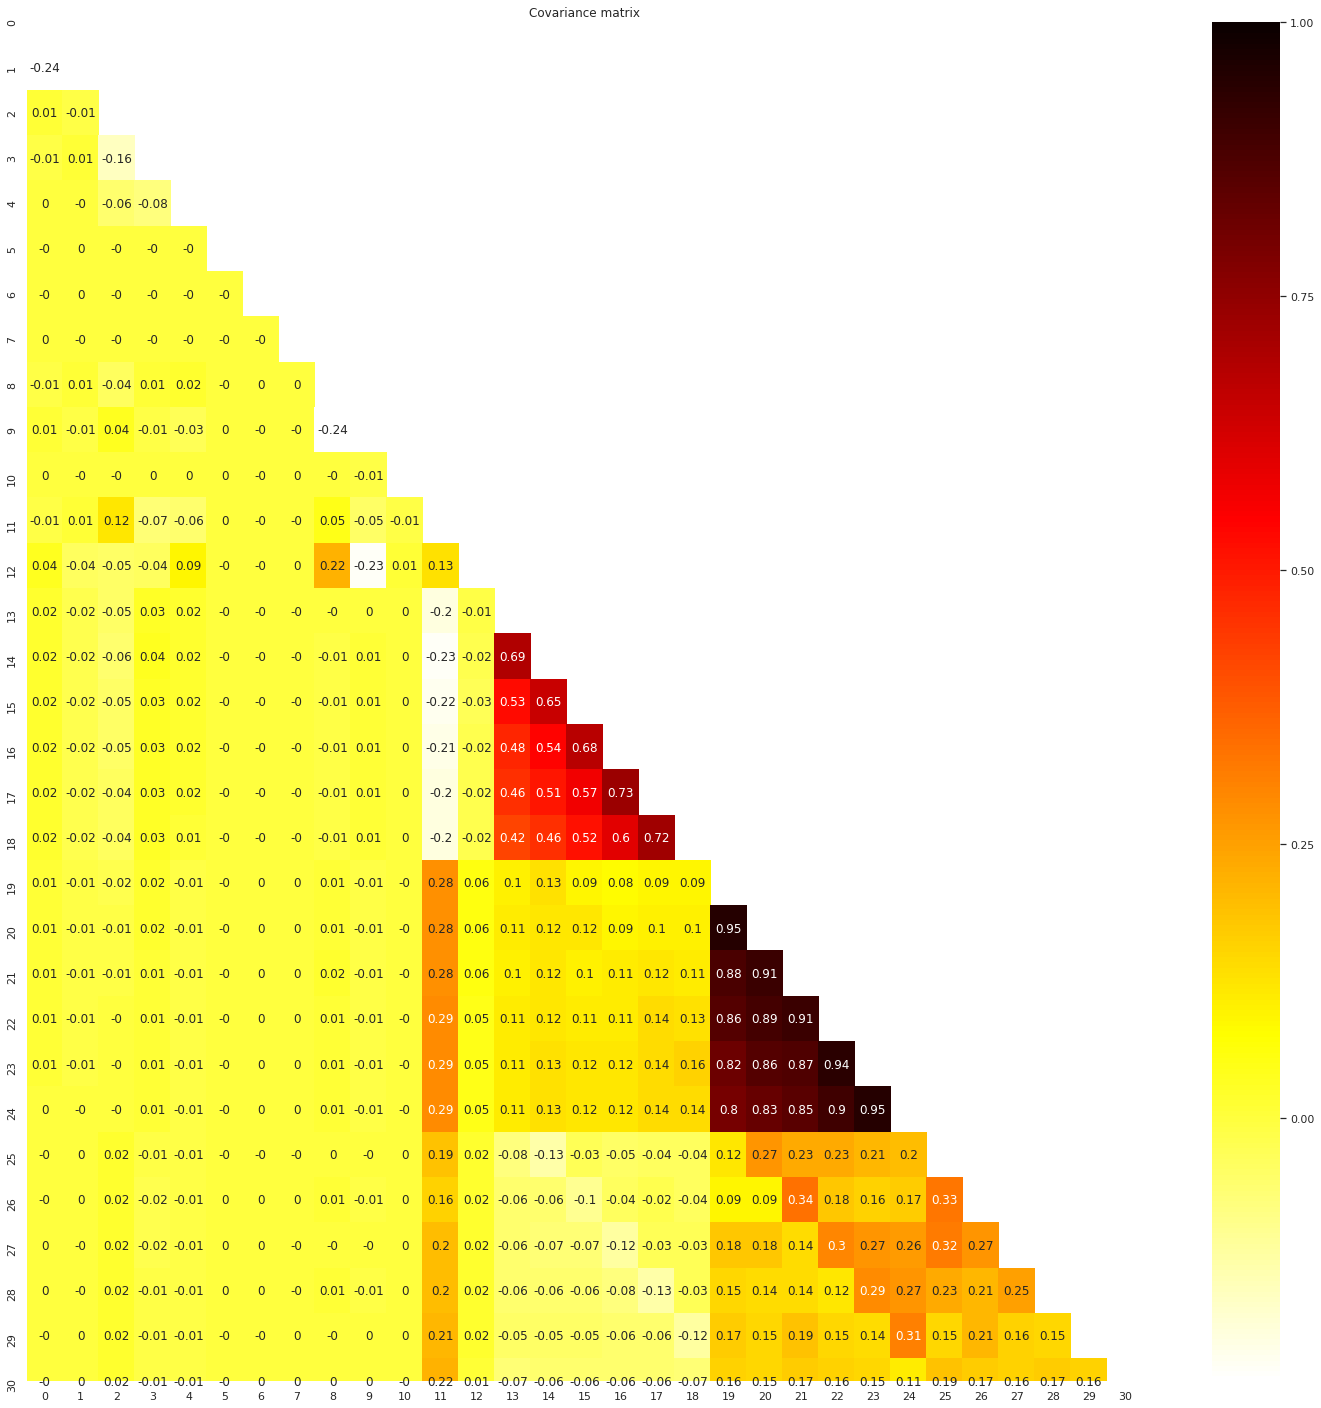

In [50]:
creditpd = pd.DataFrame(XTrain_cc)
covmat = creditpd.cov().round(2)

# Generate a mask for the upper triangle
mask = np.zeros_like(covmat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(25,25))
sn.heatmap(data=covmat,mask=mask,cmap='hot_r', annot=True)
plt.title("Covariance matrix")
plt.show()

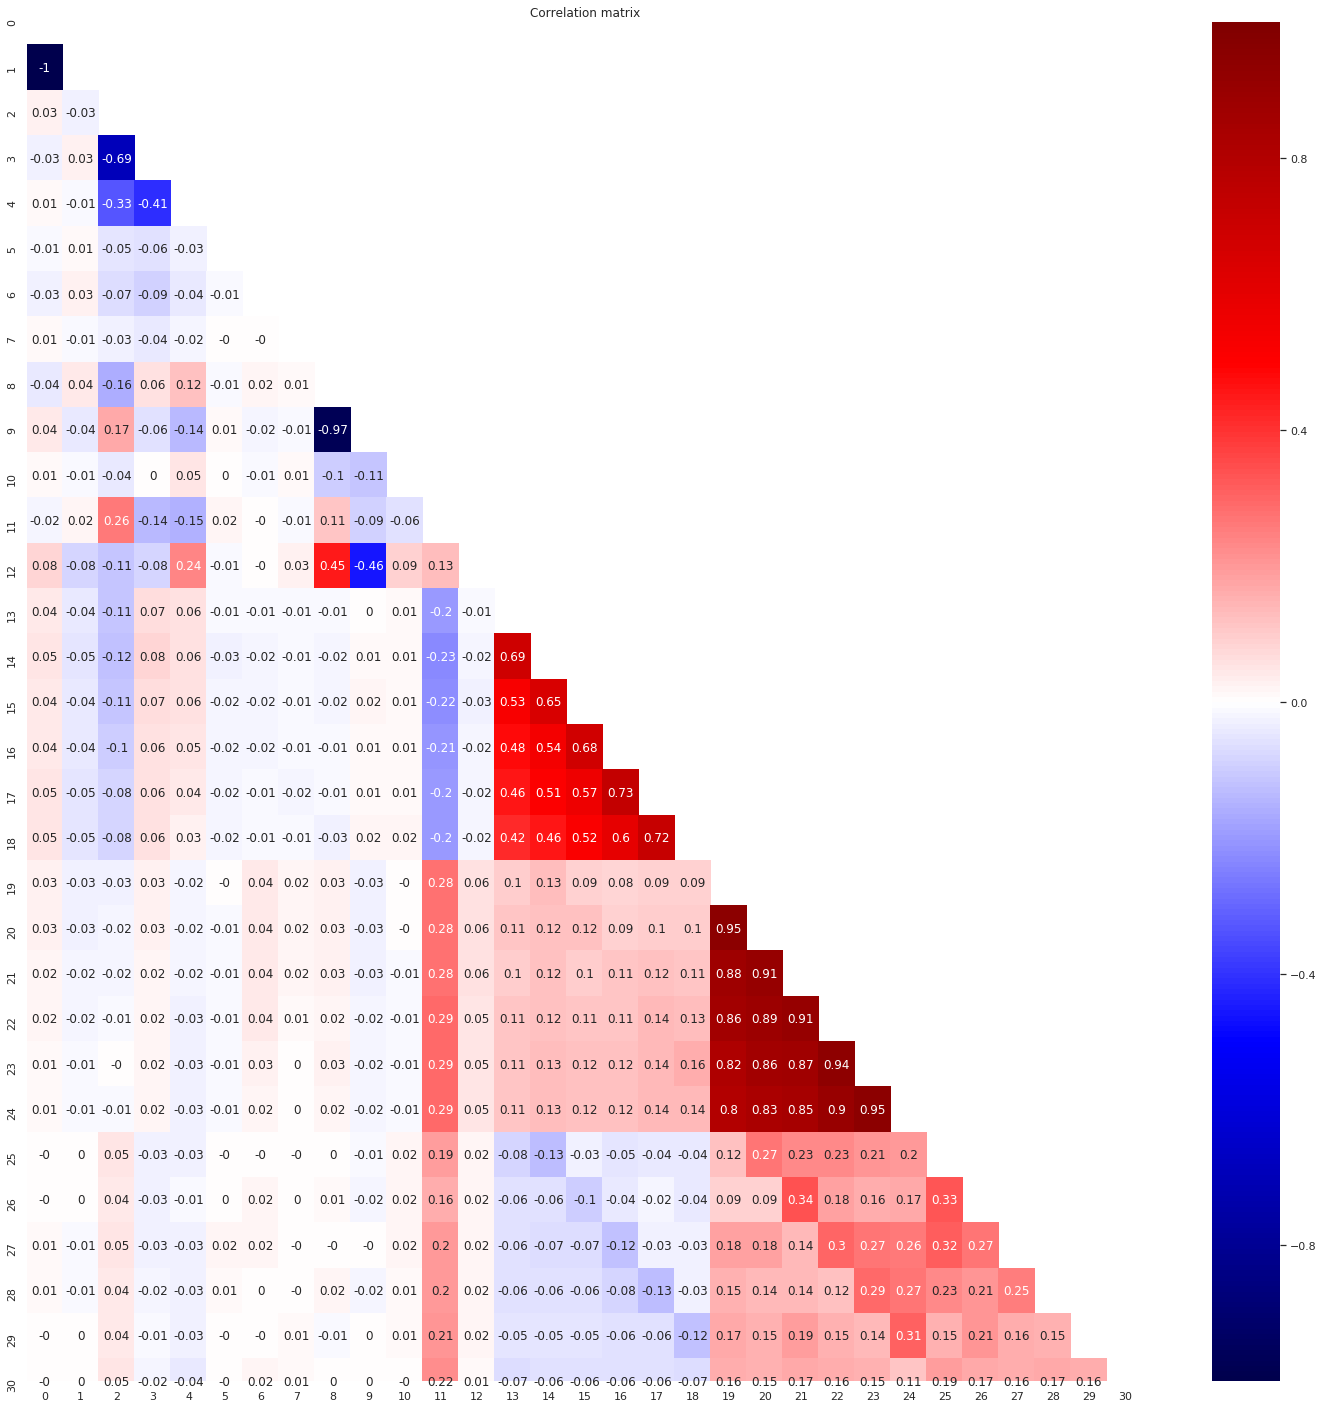

In [51]:
creditpd = pd.DataFrame(XTrain_cc)
corrmat = creditpd.corr().round(2)

# Generate a mask for the upper triangle
mask = np.zeros_like(corrmat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(25,25))
sn.heatmap(cmap='seismic',data=corrmat,mask=mask, annot=True)
plt.title("Correlation matrix")
plt.show()

In [57]:
nodes_per_layer = [100,100]
activation_per_layer = ['ReLU','ReLU']

In [58]:
# train network

CreditCard = binaryNN(XTrain_cc,np.squeeze(yTrain_cc),XTest_cc,np.squeeze(yTest_cc),nodes_per_layer,activation_per_layer,epochs=100)
CreditCard.train()

Test set accuracy: 0.1795 
Zero set accuracy: 0.2212 
Train set accuracy: 0.1771 
Test set area ratio:: 0.5493257343932724
Train set area ratio: 0.5710060526969081


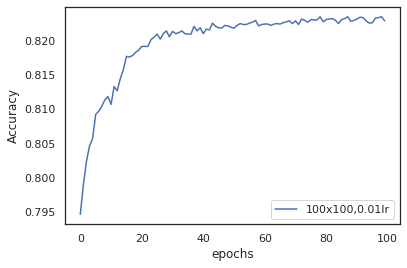

In [69]:
#find accuracy scores
Y_test_hat_cc = CreditCard.forward_propagation(XTest_cc)
# # Accuracy achieved on the test set
acc_test_cc = CreditCard.accuracy(Y_test_hat_cc, yTest_cc)
print("Test set accuracy: {:.4f} ".format(1-acc_test_cc))
zerot = np.zeros(yTest_cc.shape[0])
acc_test_cc2 = CreditCard.accuracy(np.transpose(yTest_cc.reshape((yTest_cc.shape[0], 1))), np.transpose(zerot.reshape((zerot.shape[0], 1))))

acc_test_cc2 = CreditCard.accuracy(yTest_cc,zerot)
print("Zero set accuracy: {:.4f} ".format(1-acc_test_cc2))
Y_train_hat_cc = CreditCard.forward_propagation(XTrain_cc)
# # Accuracy achieved on the test set
acc_train_cc = CreditCard.accuracy(Y_train_hat_cc, yTrain_cc)
print("Train set accuracy: {:.4f} ".format(1-acc_train_cc))



print("Test set area ratio::",calc_area_ratio(Y_test_hat_cc.T,yTest_cc)[0])
print("Train set area ratio:",calc_area_ratio(Y_train_hat_cc.T,yTrain_cc)[0])

plt.figure()
plt.plot(CreditCard.accuracy_history,label="100x100,0.01lr")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# PCA testing

In [71]:
#reduce dims
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
import time

nodes_per_layer = [100,100]
activation_per_layer = ['ReLU','ReLU']

no_pca = binaryNN(XTrain_cc,np.squeeze(yTrain_cc),XTest_cc,np.squeeze(yTest_cc),nodes_per_layer,activation_per_layer,epochs=100)
no_pca.train()

In [72]:
#find accuracy scores
Y_test_hat_cc = no_pca.forward_propagation(XTest_cc)
# # Accuracy achieved on the test set
acc_test_cc = no_pca.accuracy(Y_test_hat_cc, yTest_cc)
print("Test set accuracy: {:.4f} ".format(1-acc_test_cc))
zerot = np.zeros(yTest_cc.shape[0])
acc_test_cc2 = no_pca.accuracy(np.transpose(yTest_cc.reshape((yTest_cc.shape[0], 1))), np.transpose(zerot.reshape((zerot.shape[0], 1))))
acc_test_cc2 = no_pca.accuracy(yTest_cc,zerot)
print("Zero set accuracy: {:.4f} ".format(1-acc_test_cc2))
Y_train_hat_cc = no_pca.forward_propagation(XTrain_cc)
# # Accuracy achieved on the test set
acc_train_cc = no_pca.accuracy(Y_train_hat_cc, yTrain_cc)
print("Train set accuracy: {:.4f} ".format(1-acc_train_cc))
print("Test set area ratio::",calc_area_ratio(Y_test_hat_cc.T,yTest_cc)[0])
print("Train set area ratio:",calc_area_ratio(Y_train_hat_cc.T,yTrain_cc)[0])

Test set accuracy: 0.1795 
Zero set accuracy: 0.2212 
Train set accuracy: 0.1771 
Test set area ratio:: 0.5493257343932724
Train set area ratio: 0.5710060526969081


In [105]:
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
n_comp = 18
pca = PCA(n_components=n_comp)
X2D = pca.fit_transform(XTrain_cc)
X2Dt = pca.transform(XTest_cc)
nodes_per_layer = [100,100]
activation_per_layer = ['ReLU','ReLU']
with_pca = binaryNN(X2D,np.squeeze(yTrain_cc),X2Dt,np.squeeze(yTest_cc),nodes_per_layer,activation_per_layer,epochs=100)
with_pca.train()

In [124]:
#find accuracy scores
Y_test_hat_cc = with_pca.forward_propagation(X2Dt)
# # Accuracy achieved on the test set
acc_test_cc = with_pca.accuracy(Y_test_hat_cc, yTest_cc)
print("Test set accuracy: {:.4f} ".format(1-acc_test_cc))
zerot = np.zeros(yTest_cc.shape[0])
acc_test_cc2 = with_pca.accuracy(np.transpose(yTest_cc.reshape((yTest_cc.shape[0], 1))), np.transpose(zerot.reshape((zerot.shape[0], 1))))
acc_test_cc2 = with_pca.accuracy(yTest_cc,zerot)
print("Zero set accuracy: {:.4f} ".format(1-acc_test_cc2))
Y_train_hat_cc = with_pca.forward_propagation(X2D)
# # Accuracy achieved on the test set
acc_train_cc = with_pca.accuracy(Y_train_hat_cc, yTrain_cc)
print("Train set accuracy: {:.4f} ".format(1-acc_train_cc))
print("Test set area ratio::",calc_area_ratio(Y_test_hat_cc.T,yTest_cc)[0])
print("Train set area ratio:",calc_area_ratio(Y_train_hat_cc.T,yTrain_cc)[0])
# print(XTrain_cc[0,:])
# print(np.shape(pca.components_))

Test set accuracy: 0.1792 
Zero set accuracy: 0.2212 
Train set accuracy: 0.1764 
Test set area ratio:: 0.5391742962509435
Train set area ratio: 0.5657138895062443


In [77]:
# would expect trobule with small batches on biased data sets?

In [286]:
def plot_lift(h,method):
    backg=np.array(Image.open("/home/janfki/Desktop/ML/Project2/Gains_NN.jpg"))

    fig, ax2 = plt.subplots(1,1)
    ax2.plot(h[1].get_xdata(), h[1].get_ydata(),'r--',dashes=(3,3), lw=3, label='fitted curve')
    ax2.legend(loc='right')
    ax2.imshow(backg,aspect='auto',extent=[0,1,0,1.065])

    ax2.set_title(method)
    ax2.set_xlabel('Number of total data',fontweight='bold')
    ax2.set_ylabel('Cumulative number of target data',fontweight='bold')

    ax2.set_xticks((0,0.33,0.66,1))
    ax2.set_xticklabels((0,5000,10000,15000))
    ax2.set_yticks((0,0.15,0.307,0.46,0.614,0.77,0.92,1.065))
    ax2.set_yticklabels((0,500,1000,1500,2000,2500,3000,3500));  
    plt.show()

In [79]:
def calc_area_ratio(pred,real):
    fig,ax = plt.subplots(1,1)
    y_te = two(pred)
    skplt.metrics.plot_cumulative_gain(real.ravel(), y_te,ax=ax)
    ax.grid(b=None)
    hh,ll=ax.get_legend_handles_labels()
    plt.close()
    defaults = sum(real == 1)
    total = len(real)
    defaultRate = defaults/total

    bestie=bestCurve(defaults,total,defaultRate)
    dia = np.linspace(0,1,15000)
    classi=hh[1].get_ydata()
    diff_c = np.sum(classi)-np.sum(dia)
    diff_b = np.sum(bestie[1])-np.sum(dia)+1 #adding a 1 on the end of bestie for dimensions?
    area_ratio = diff_c/diff_b
    return area_ratio,hh

In [80]:
def bestCurve(defaults, total, defaultRate): #create best curve
    x = np.linspace(0, 1, total)
    
    y1 = np.linspace(0, 1, defaults)
    y2 = np.ones(total-defaults)
    y3 = np.concatenate([y1,y2])
    return x, y3

In [81]:
def two(y): #helper function for lift curve plotting
    y_two = np.zeros(len(y))
    for i in range(len(y)):
        y_two[i] = 1-y[i]
    return np.c_[y_two,y]

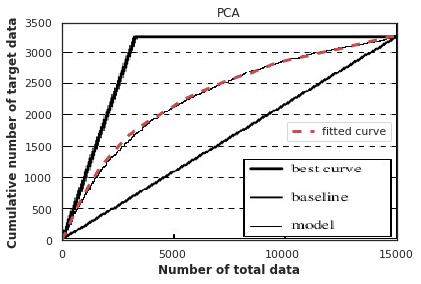

In [287]:
from PIL import Image
plot_lift(calc_area_ratio(Y_test_hat_cc.T, yTest_cc)[1],'PCA')

In [99]:
test_accuracy_=[]
for i in range(XTrain_cc.shape[1]):
    n_comp = i
    pca = PCA(n_components=n_comp)
    X2D = pca.fit_transform(XTrain_cc)
    X2Dt = pca.transform(XTest_cc)
    nodes_per_layer = [100,100]
    activation_per_layer = ['ReLU','ReLU']
    with_pca = binaryNN(X2D,np.squeeze(yTrain_cc),X2Dt,np.squeeze(yTest_cc),nodes_per_layer,activation_per_layer,epochs=100)
    with_pca.train()
    y_hatted = with_pca.forward_propagation(X2Dt)
    test_accuracy_.append(with_pca.accuracy(y_hatted, yTest_cc))

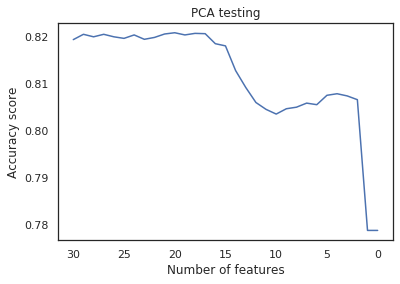

In [104]:
plt.figure()
plt.plot(test_accuracy_)
plt.gca().invert_xaxis()
plt.title("PCA testing")
plt.xlabel("Number of features")
plt.ylabel("Accuracy score")
plt.show()

# an attempt at translating "pca features" back to real features

In [214]:
n_comp = 18
pca = PCA(n_components=n_comp)
X2D = pca.fit_transform(XTrain_cc)
print(np.shape(X2D))

df = pd.DataFrame(XTrain_cc)

i = np.identity(df.shape[1])
coef=pca.transform(i)
coefmatr = pd.DataFrame(coef)

(15000, 18)


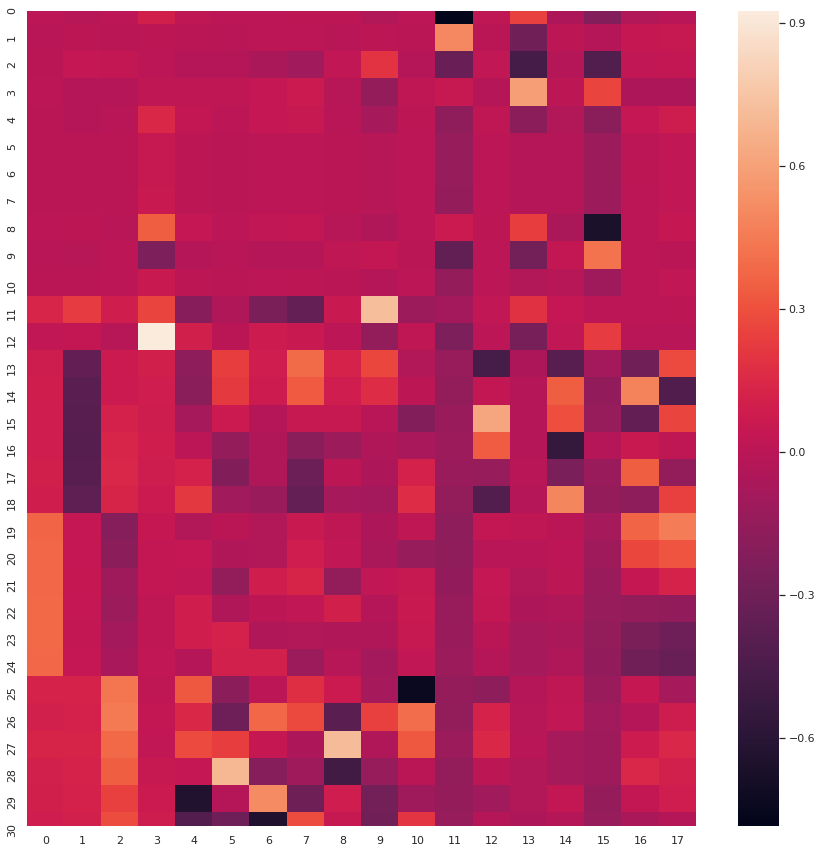

In [143]:
plt.figure(figsize=(15,15))
sn.heatmap(coefmatr)
plt.show()

(31,)
[ 5  7  6 10  1  4  3  9  0  8 22 21  2 20 23 19 24 12 16 17 11 25 28 15
 27 29 30 26 14 18 13]


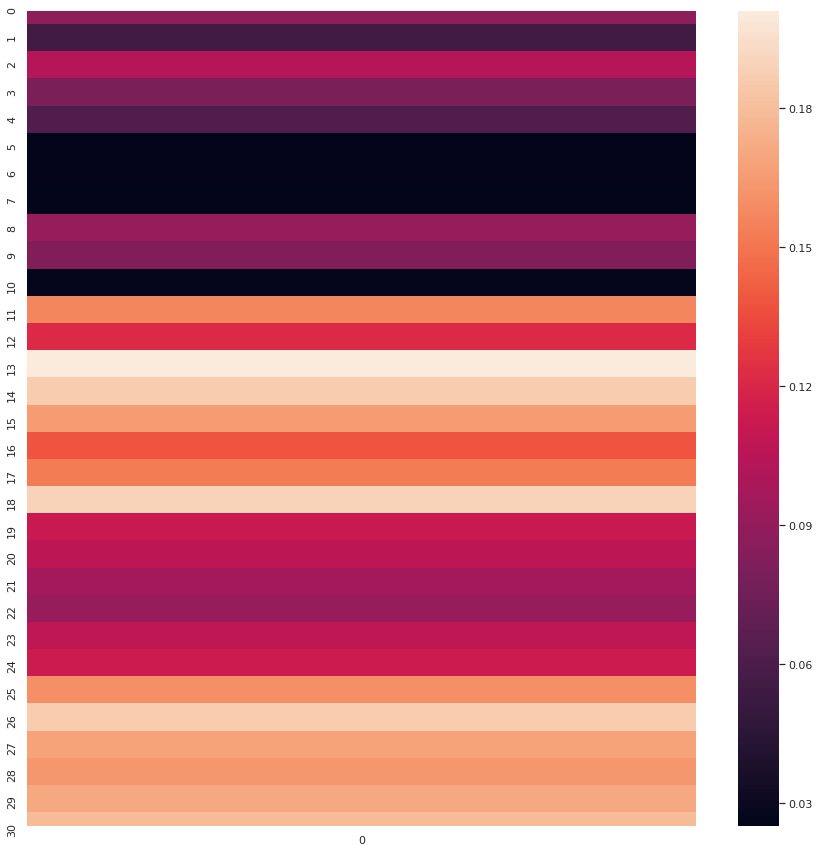

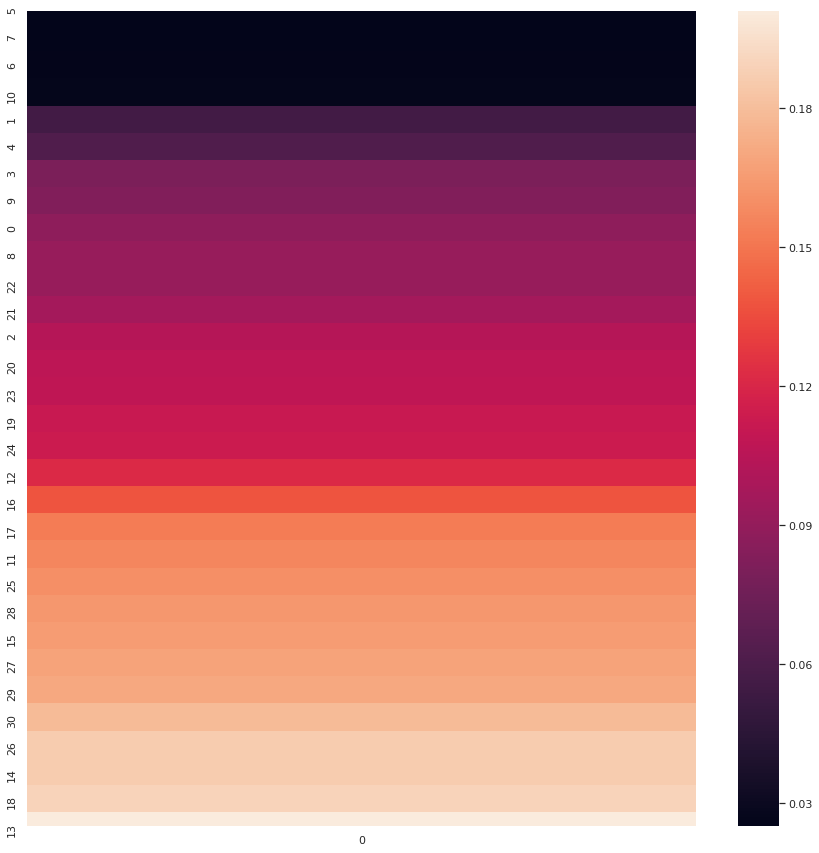

In [224]:
coefmatrm = np.mean(np.abs(coefmatr),axis=1)
print(np.shape(coefmatrm))
order = np.argsort(coefmatrm)
features = np.arange(0,31)
features = features[order]
print(features)
cosort = coefmatrm[order]
# display(coefmatr[:1])
# display(coefmatrm[:1])
plt.figure(figsize=(15,15))
sn.heatmap(coefmatrm[:,np.newaxis])
plt.show()
plt.figure(figsize=(15,15))
sortstuff = sn.heatmap(cosort[:,np.newaxis])
sortstuff.set(yticklabels=features)
plt.show()

In [232]:
cutter=18
XTrain_cc_decimated = XTrain_cc[:,features[cutter:]]
XTest_cc_decimated = XTest_cc[:,features[cutter:]]
print(np.shape(XTrain_cc_decimated))
print(reversed(features))

(15000, 13)


In [230]:
print(XTrain_cc_decimated[0,:])
print(XTrain_cc[0,:])

[-1.17839005 -0.04292729  0.17160635 -0.32414976 -0.17644558 -0.11547126
  1.9794801  -0.12050296 -0.12220393 -0.21876009 -0.11846012 -1.20126368
  0.89163167]
[ 1.          0.          0.          0.          1.          0.
  0.          0.          1.          0.          0.          0.17160635
  2.02948434  0.89163167 -0.11846012 -0.11547126 -1.17839005 -0.04292729
 -1.20126368 -0.70073274 -0.70382799 -0.69609536 -0.03966933 -0.48711306
 -0.60321633 -0.32414976 -0.21876009  1.9794801  -0.17644558 -0.12050296
 -0.12220393]


In [231]:
deci_pca = binaryNN(XTrain_cc_decimated,np.squeeze(yTrain_cc),XTest_cc_decimated,np.squeeze(yTest_cc),nodes_per_layer,activation_per_layer,epochs=100)
deci_pca.train()

In [233]:
#find accuracy scores
Y_test_hat_cc = deci_pca.forward_propagation(XTest_cc_decimated)
# # Accuracy achieved on the test set
acc_test_cc = deci_pca.accuracy(Y_test_hat_cc, yTest_cc)
print("Test set accuracy: {:.4f} ".format(1-acc_test_cc))
zerot = np.zeros(yTest_cc.shape[0])
acc_test_cc2 = deci_pca.accuracy(np.transpose(yTest_cc.reshape((yTest_cc.shape[0], 1))), np.transpose(zerot.reshape((zerot.shape[0], 1))))
acc_test_cc2 = deci_pca.accuracy(yTest_cc,zerot)
print("Zero set accuracy: {:.4f} ".format(1-acc_test_cc2))
Y_train_hat_cc = deci_pca.forward_propagation(XTrain_cc_decimated)
# # Accuracy achieved on the test set
acc_train_cc = deci_pca.accuracy(Y_train_hat_cc, yTrain_cc)
print("Train set accuracy: {:.4f} ".format(1-acc_train_cc))
print("Test set area ratio::",calc_area_ratio(Y_test_hat_cc.T,yTest_cc)[0])
print("Train set area ratio:",calc_area_ratio(Y_train_hat_cc.T,yTrain_cc)[0])
# print(XTrain_cc[0,:])
# print(np.shape(pca.components_))

Test set accuracy: 0.1785 
Zero set accuracy: 0.2212 
Train set accuracy: 0.1762 
Test set area ratio:: 0.5409504742011817
Train set area ratio: 0.5479209498922705


In [194]:
# not really a 1-1 relationship here?

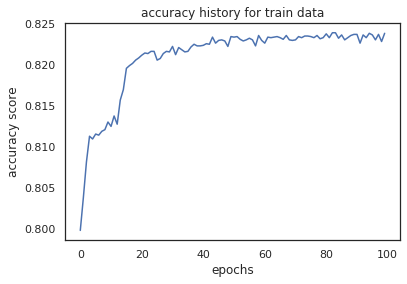

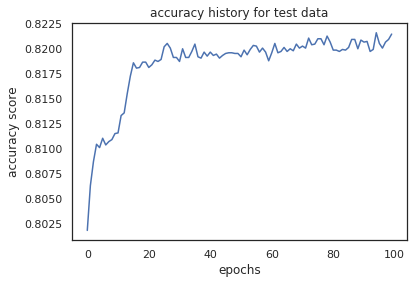

In [236]:
plt.figure()
plt.plot(deci_pca.accuracy_history)
plt.title("accuracy history for train data")
plt.xlabel("epochs")
plt.ylabel("accuracy score")
plt.show()
plt.figure()
plt.plot(deci_pca.accuracy_history_test)
plt.title("accuracy history for test data")
plt.xlabel("epochs")
plt.ylabel("accuracy score")
plt.show()

In [223]:
print(XTrain_cc[0,:])

[ 1.          0.          0.          0.          1.          0.
  0.          0.          1.          0.          0.          0.17160635
  2.02948434  0.89163167 -0.11846012 -0.11547126 -1.17839005 -0.04292729
 -1.20126368 -0.70073274 -0.70382799 -0.69609536 -0.03966933 -0.48711306
 -0.60321633 -0.32414976 -0.21876009  1.9794801  -0.17644558 -0.12050296
 -0.12220393]


In [245]:
feature_names = ['Male','Female','Gradschool','university','highschool','othereducations','unknowneducation1',\
                 'unknowneducation2','married','single','othermarriagestatus','LIMIT_B','age','PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6',\
                 'BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6',\
                 'PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']
    


In [285]:
# print(np.shape(feature_names))
# print(features)
# print(type(feature_names))
fettb= np.array(feature_names)#[order]

fett = np.array(feature_names)#[order]
fett2=fett[order]
# print(fett)
# print(fett2)
# featses=np.c_[features,feature_names]
# # print(np.shape(featses))
# from operator import itemgetter
# # featses.sort(key=lambda x: x[1])
# featsort=sorted(featses,key=itemgetter(0))
# # print(featses)
# # print(featsort)
# pd.DataFrame((featsort))

# display(pd.DataFrame(fettb))
# pd.DataFrame(fett)
display(pd.DataFrame(reversed(fett2)))# pd.DataFrame(reversed(fett2))

,0
0,PAY_0
1,PAY_6
2,PAY_2
3,PAY_AMT2
4,PAY_AMT6
5,PAY_AMT5
6,PAY_AMT3
7,PAY_3
8,PAY_AMT4
9,PAY_AMT1
